Question 01


Radius (r): 9.742360096347989
Center (x, y): (106.0, 256.0)


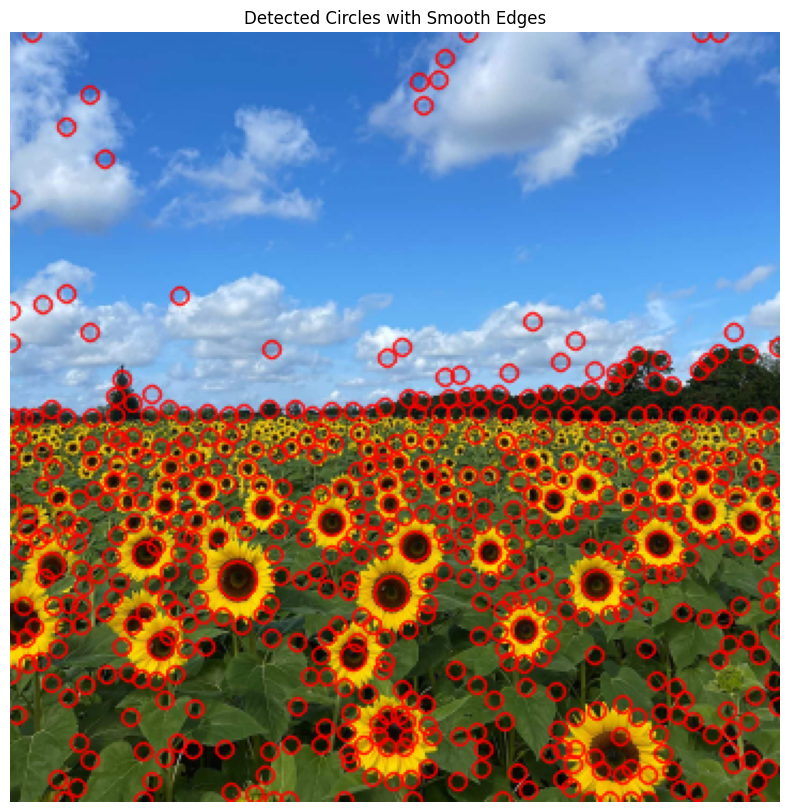

In [9]:
import cv2 as cv
import numpy as np
from skimage.feature import blob_log
import matplotlib.pyplot as plt
from math import sqrt

# Read the image
img = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv.GaussianBlur(gray, (9,9), 0.1)
laplacian = cv.Laplacian(blurred, cv.CV_64F)


# Define parameters for blob detection
min_sigma = 3
max_sigma = 10
threshold = 4

# Detect blobs using Laplacian of Gaussians
blobs = blob_log(laplacian, min_sigma=min_sigma,max_sigma=max_sigma, threshold=threshold)
# blobs=blob_log(laplacian, min_sigma=1, max_sigma=30, threshold=0.1, overlap=0.01, log_scale=False)

blobs[:, 2] = blobs[:, 2] * sqrt(2)

max_radius_index = np.argmax(blobs[:, 2])
largest_circle_params = blobs[max_radius_index]
y, x, r = largest_circle_params
print(f"Radius (r): {r}")
print(f"Center (x, y): ({x}, {y})")

# Draw circles on the original grayscale image
for blob in blobs:
    y, x, r = blob  # Blob format is (y, x, r)
    cv.circle(img, (int(x), int(y)), int(r), (0,0,255),thickness=1, lineType=cv.LINE_AA)  # Draw circles in white

# Display the result

# cv.imshow('Detected Circles', gray_three_channel)
# cv.waitKey(0)
# cv.destroyAllWindows()

plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Circles with Smooth Edges')
plt.show()

Question (02)


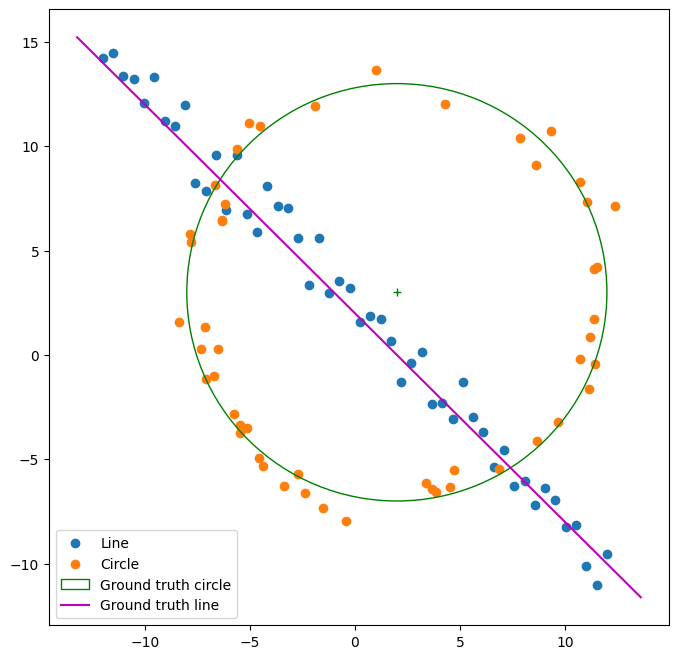

In [12]:
from scipy.optimize import minimize
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import  circle_fit as cf 
import tikzplotlib

np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center of the circle
s = r / 16

t = np.random.uniform(0, 2*np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)

X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s * np.random.randn(half_n)

X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.123323560816004e-09
            Iterations: 11
            Function evaluations: 49
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0786208103638998e-11
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.975350980935442e-09
            Iterations: 9
            Function evaluations: 40
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0867735142075082e-07
            Iterations: 9
            Function evaluations: 40
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4542360058045348e-10
            Iterations: 6
            F

3.1217680108657674e-09

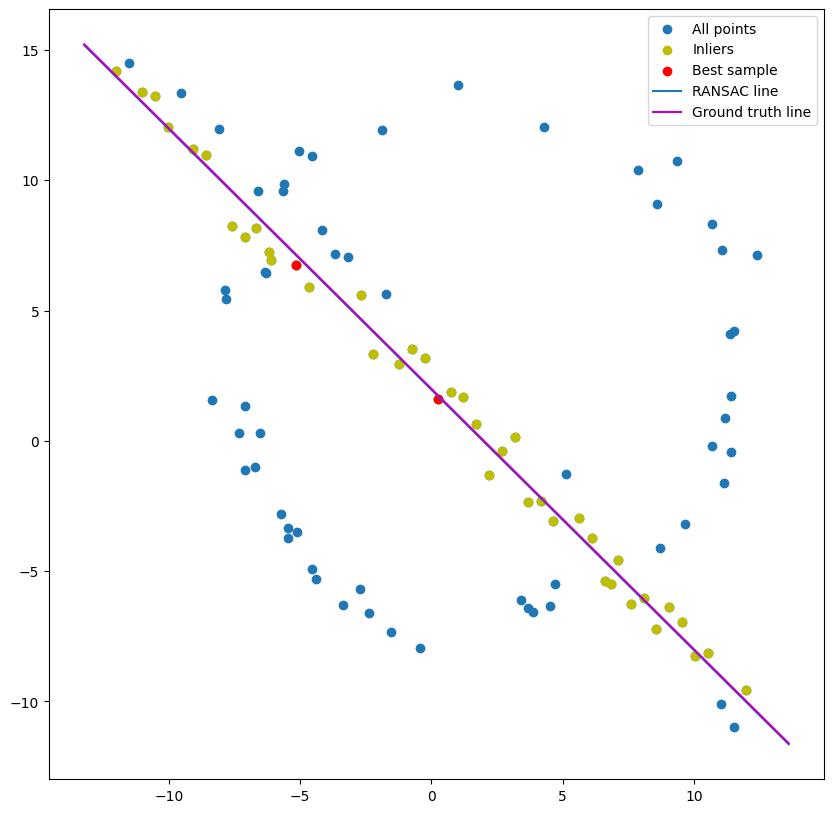

In [13]:
import math
from scipy.optimize import minimize
import  circle_fit as cf 

N = X.shape[0]
X_ = X

def line_equation_from_points(x1,y1,x2,y2):
    #Calculate the direction vector (del_x,del_y)
    del_x = x2 - x1
    del_y = y2 - y1

    #Calculate normalized vactor (a,b)
    magnitude = math.sqrt(del_x**2 + del_y**2)
    a = del_y / magnitude
    b = -del_x / magnitude

    #Calculate d
    d = (a*x1) + (b*y1)

    #return the line equation in the form of ax+ by = d
    return a,b,d

# RANSAC to fit a line
def line_tls(x , indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))


#Constraint 
def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

#Computing the consensus (inliers)
def consensus_line(X_,x,t):
    a, b, d = x[0], x[1], x[2]
    error  = np.abs(a*X_[:,0] + b*X_[:,1] - d)
    return error<t

t = 1 #Threshold value to determine data points that are fitted well by model
d = 0.4*N #Number of close data points required to assert that a model fits well to data
s = 2

inliers_line = [] # Indices of the inliers
max_iterations = 50
iteration = 0
best_model_line = [] # Best model normal to (a,b) and distance from origin d
best_error = np.inf
best_sample_line = [] # Three point sample leading to the best model computation
res_only_with_sample = [] # Result (a,b,d) only using the best sample
best_inliers_line = [] # Inliers using the best sample

while iteration < max_iterations:
    indices = np.random.randint(0,N,s)
    x0 = np.array([1,1,0]) # initial estimate
    res = minimize(fun = line_tls, args=(indices), x0 = x0, tol = 1e-6, constraints=cons, options = {'disp':True})
    inliers_line = consensus_line(X_,res.x,t) #computing inliers
    # print('res.x: ',res.x)
    # print('iteration = ', iteration, ' , No. inliers = ', inliers_line.sum())
    if inliers_line.sum() > d:
        x0 = res.x
        #computing the new model using all inliers
        res = minimize(fun=line_tls, args=inliers_line, x0 = x0, tol = 1e-6, constraints=cons, options = {'disp':True})
        # print(res.x, res.fun)
        if res.fun < best_error:
            # print("A better model is found ...", res.x, res.fun)
            best_model_line = res.x
            best_error = res.fun
            best_sample_line = X_[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line
    iteration += 1
print("Best line model" , best_model_line)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(X_[:,0],X_[:,1], label='All points')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

res.fun

In [14]:
#Obtaining the circle given three points on which it should lie

def circ_through_points(x1, x2, x3):
    denominator_1 = ( (x1[0] - x2[0]) * (x2[1] - x3[1]) - (x2[1] - x1[1]) * (x3[0] - x2[0]) )
    denominator_2 = ( (x1[0] - x2[0]) * (x2[1] - x3[1]) - (x2[1] - x1[1]) * (x3[0] - x2[0]) )

    if denominator_1 != 0 and denominator_2 != 0:
        a = 0.5 * ( (x2[1] - x3[1]) * (x1[0]**2 + x1[1]**2 - x2[0]**2 - x2[1]**2) + (x2[1] - x1[1]) * (x2[0]**2 + x2[1]**2 - x3[0]**2 - x3[1]**2) ) / denominator_1
        b = 0.5 * ( (x1[0] - x2[0]) * (x2[0]**2 + x2[1]**2 - x3[0]**2 - x3[1]**2) + (x3[0] - x2[0]) * (x1[0]**2 + x1[1]**2 - x2[0]**2 - x2[1]**2) ) / denominator_2
        c = -x3[0]**2 - x3[1]**2 + 2*a*x3[0] + 2*b*x3[1]

        r = np.sqrt(a**2 + b**2 - c)
    else:
        a,b,r = None, None, None

    return a, b, r

In [15]:
#Calculate the inliers according to the given threshold(d)

def get_inlier(a, b, r, X, d):
    count = 0
    best_fit_inliers = None

    for i in range(X.shape[0]):
        distance = abs( ( (X[i,0] - a)**2 + (X[i,1] - b)**2 ) ** 0.5 - r )

        if distance < d:
            count += 1

            if type(best_fit_inliers) == type(None):
                best_fit_inliers = np.array([X[i,:]])
            else:
                best_fit_inliers = np.concatenate((best_fit_inliers, X[i,:].reshape(1, -1)), axis=0)
    
    return count, best_fit_inliers

In [16]:
def RANSAC(X): 
    S = 3
    d = 1.96 #gaussian threshold for selecting a 
    #correct outlier with p1 = 95% probability.
    e = 0.50
    p = 0.99
    N = int(np.ceil(np.log(1-p)/np.log(1-(1-e)**S)))

    best_fit_circle = None
    best_fit_x = None
    best_inlier_count = 0

    for _ in range(N):
        x = []

        for i in range(S):
            hold = X[np.random.randint(0, 100), :]
            
            if len(x) == 0:
                x.append(hold)
            elif np.array_equal(hold, x[-1]):                
                while np.array_equal(hold, x[-1]):
                    hold = X[np.random.randint(0, 100), :]
                
                x.append(hold)
            else:
                x.append(hold)
        
        a, b, r = circ_through_points(x[0], x[1], x[2])

        if a == None:
            continue

        count, inliers = get_inlier(a, b, r, X, d)

        if count > best_inlier_count:
            best_fit_circle = plt.Circle((a, b), r, color='b', fill=False, label="Best Sample")
            best_fit_x = x
            best_fit_inliers = inliers
            best_inlier_count = count
    
    if best_inlier_count < e:
        print("The RANSAC algorithm did not find a suitable model")
        return None, None, None, None

    xc,yc,r,_ = cf.least_squares_circle(best_fit_inliers)

    ransac_circle = plt.Circle((xc, yc), r, color='m', fill=False, label="RANSAC")
    
    return ransac_circle, best_fit_circle, best_fit_x, best_fit_inliers

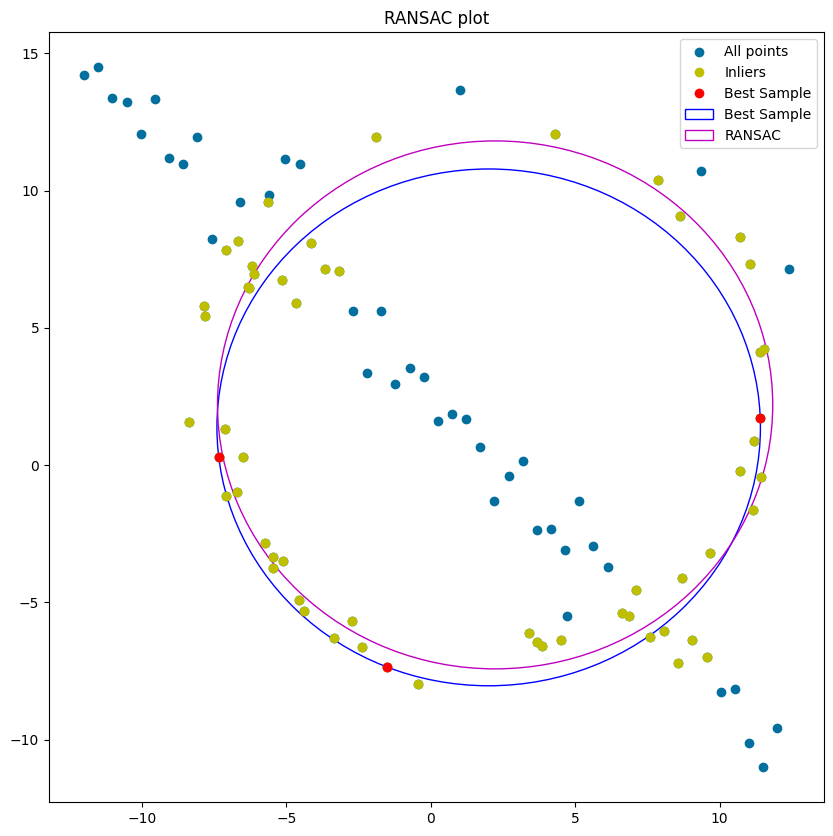

In [17]:
ransac_circle, best_fit_circle, x, inliers = RANSAC(X)


if ransac_circle != None:
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    ax.scatter(X_circ[:,0], X_circ[:,1], color="#026f9e")
    ax.scatter(X_line[:,0], X_line[:,1], color="#026f9e", label="All points")

    if type(inliers) != type(None):
        for point in inliers:
            if np.array_equal(point, inliers[-1]):
                ax.plot(point[0], point[1], 'yo', label="Inliers")
            else:
                ax.plot(point[0], point[1], 'yo')


    for point in x:
        if np.array_equal(point, x[-1]):
            ax.plot(point[0], point[1], 'ro', label="Best Sample")
        else:
            ax.plot(point[0], point[1], 'ro')

    ax.add_patch(best_fit_circle)
    ax.add_patch(ransac_circle)
    ax.set_title("RANSAC plot")
    ax.legend(loc="upper right")